In [67]:
import numpy as np
import pylcp
from pylcp.common import progressBar
import matplotlib.pyplot as plt
import scipy.stats as stat
import scipy.integrate as intg
from math import sqrt, sin, cos
import time

### Hamiltonian

In [46]:
atom = pylcp.atom("41K")

In [47]:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[0].J, atom.I, atom.state[0].gJ, atom.gI,
    atom.state[0].Ahfs/atom.state[2].gammaHz, Bhfs=0, Chfs=0,
    muB=1)
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[2].J, atom.I, atom.state[2].gJ, atom.gI,
    Ahfs=atom.state[2].Ahfs/atom.state[2].gammaHz,
    Bhfs=atom.state[2].Bhfs/atom.state[2].gammaHz, Chfs=0,
    muB=1)

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(
    atom.state[0].J, atom.state[2].J, atom.I)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))

hamiltonian_D2 = pylcp.hamiltonian(H_g_D2, H_e_D2, mu_q_g_D2, mu_q_e_D2, dijq_D2)
hamiltonian_D2.set_mass(atom.mass)

In [48]:
hamiltonian_D2.print_structure()

[[((<g|H_0|g> 8x8), (<g|mu_q|g> 8x8)) (<g|d_q|e> 8x16)]
 [(<e|d_q|g> 16x8) ((<e|H_0|e> 16x16), (<e|mu_q|e> 16x16))]]


### Beams

In [49]:
# beam parameters
s = 1.0 # intensity
det = -2.0 # detuning
alpha = 1.0

In [50]:
laserBeams_cooling_D2 = pylcp.conventional3DMOTBeams(
    s=s, delta=(E_e_D2[0] - E_g_D2[1]) + det)
laserBeams_repump_D2 = pylcp.conventional3DMOTBeams(
    s=s, delta=(E_e_D2[1] - E_g_D2[0]) + det)
laserBeams_D2 = laserBeams_cooling_D2 + laserBeams_repump_D2

### Magnetic field

In [51]:
magField = pylcp.quadrupoleMagneticField(alpha)

### Force Profile

In [52]:
x = np.arange(-5, 5.1, 0.2)
v = np.arange(-5, 5.1, 0.2)

dx = np.mean(np.diff(x))
dv = np.mean(np.diff(v))

X, V = np.meshgrid(x, v)

# Define the trap:
trap_D2 = pylcp.rateeq(
    laserBeams_D2, magField, hamiltonian_D2,
    include_mag_forces=False
)
trap_D2.generate_force_profile(
    [np.zeros(X.shape), np.zeros(X.shape), X],
    [np.zeros(V.shape), np.zeros(V.shape), V],
    name='Fz')
FzK_D2 = trap_D2.profile['Fz'].F[2]

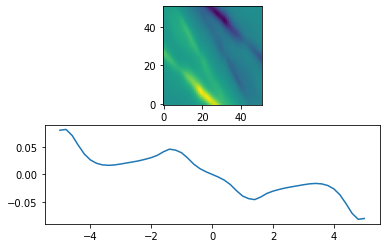

In [53]:
fig_fp, ax_fp = plt.subplots(2, 1)
ax_fp[0].imshow(FzK_D2, origin='lower')
ax_fp[1].plot(X[int(X.shape[0]/2), :],
              FzK_D2[int(X.shape[0]/2), :])

### Temperature simulation

Simulate many atoms to get the temperature. Use the Maxwell-Boltzmann distribution for the initial velocities.

the total from 0 to 1057.482717 is 0.999632 with error 0.000000.



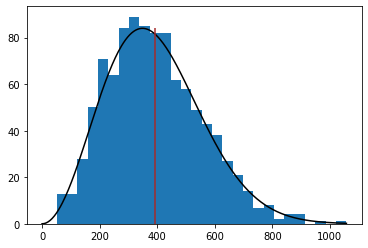

In [54]:
# test sampling of M-B distribution
t0 = 300
k = 1.38e-23

# the maxwell distribution in scipy has a form
# f(x) = sqrt(2/pi) x^2 exp(-x^2 / 2)
# we must correct for this using a constant.
# cf Schroeder pg 244
# x^2 = mv^2 / kT => v = sqrt(kT / m) x

n_sample = 1000
x = stat.maxwell.rvs(size=n_sample)
c = atom.mass / (k * t0)
v = sqrt(1 / c) * x

f = lambda v: (c / (2 * np.pi)) ** (1.5) \
    * (4 * np.pi) * v ** 2 * np.exp(-0.5 * c * v**2)
v_anly = np.linspace(0, np.amax(v), num=300)
f_anly = np.zeros(v_anly.size)
for i in range(v_anly.size):
    f_anly[i] = f(v_anly[i])

v_avg = sqrt(8 * k * t0 / (np.pi * atom.mass))    

# integrate to confirm distribution is correctly normalized
total, err = intg.quad(f, 0.0, np.amax(v))
print("the total from 0 to %f is %f with error %f.\n" % (np.amax(v), total, err))

n_bins = 28
norm = 0.5 * n_sample * np.amax(v) \
    / n_bins * (f(v_avg) + f(v_avg + np.amax(v) / n_bins)) \
    / np.amax(f_anly)
fig_mb, ax_mb = plt.subplots()
ax_mb.hist(v, bins=n_bins)
ax_mb.plot(v_anly, norm * f_anly, 'k-')
ax_mb.vlines(v_avg, 0.0, np.amax(f_anly) * norm, colors='brown')

In [82]:
# first, let's try just one atom!
# rate eqn version

t = 1.0 # evolution time
t0 = 300 # initial temp in kelvin
k = 1.38e-23

# sample velocity values from M-B dist
# also sample polar/azimuthal angles uniformly
x = stat.maxwell.rvs(size=1) # maxwell-boltzmann parameter
phi = 2 * np.pi * stat.uniform.rvs(size=1)
theta = np.pi * stat.uniform.rvs(size=1)

# convert x to v by x = sqrt(m/kT) v
# in f(v) d^3v = (m/2Pi*kT)^(3/2) exp(-mv^2/kT) d^3v
v = sqrt(k * t0 / atom.mass) * x

print("v = %f theta = %f phi = %f\n" % (v, theta, phi))

# find intial position and velocity
start_time = time.time()
v0 = v * np.array(
    [sin(phi) * cos(theta),
     sin(phi) * sin(theta),
     cos(phi)])
x0 = np.zeros(3)
# set up eq'n object and solve
eqn = pylcp.rateeq(
    laserBeams_D2, magField, hamiltonian_D2,
    r0=x0, v0=v0
)
eqn.set_initial_pop_from_equilibrium()
sol = eqn.evolve_motion(
    [0, t], freeze_axis=[False, False, False],
    random_recoil=False, progress_bar=True
)
end_time = time.time()

print("Solved in %f seconds.\n" % (end_time - start_time))

v = 474.140357 theta = 1.202923 phi = 2.861672



KeyboardInterrupt: 

In [86]:
# first, let's try just one atom!
# obe version

t = 1e-4 # evolution time
t0 = 10 # initial temp in kelvin
k = 1.38e-23

# sample velocity values from M-B dist
# also sample polar/azimuthal angles uniformly
x = stat.maxwell.rvs(size=1) # maxwell-boltzmann parameter
phi = 2 * np.pi * stat.uniform.rvs(size=1)
theta = np.pi * stat.uniform.rvs(size=1)

# convert x to v by x = sqrt(m/kT) v
# in f(v) d^3v = (m/2Pi*kT)^(3/2) exp(-mv^2/kT) d^3v
v = sqrt(k * t0 / atom.mass) * x

print("v = %f theta = %f phi = %f\n" % (v, theta, phi))

# find intial position and velocity
start_time = time.time()
v0 = v * np.array(
    [sin(phi) * cos(theta),
     sin(phi) * sin(theta),
     cos(phi)])
x0 = np.zeros(3)
# set up eq'n object and solve
eqn = pylcp.obe(
    laserBeams_D2, magField, hamiltonian_D2,
    r0=x0, v0=v0
)
eqn.set_initial_rho_from_rateeq()
sol = eqn.evolve_motion(
    [0, t], freeze_axis=[False, False, False],
    random_recoil=False, progress_bar=True
)
end_time = time.time()

print("Solved in %f seconds.\n" % (end_time - start_time))

v = 55.600993 theta = 2.212419 phi = 2.514122



UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

In [ ]:
n_atom = 1
t = 1e-4 # evolution time
t0 = 300 # initial temp in kelvin
k = 1.38e-23
solns = [] # list of solutions to rate eq'ns

# sample velocity values from M-B dist
# also sample polar/azimuthal angles uniformly
x = stat.maxwell.rvs(size=n_atom) # maxwell-boltzmann parameter
phi = 2 * np.pi * stat.uniform.rvs(size=n_atom)
theta = np.pi * stat.uniform.rvs(size=n_atom)

# convert x to v by x = sqrt(m/kT) v
# in f(v) d^3v = (m/2Pi*kT)^(3/2) exp(-mv^2/kT) d^3v
v = sqrt(k * t0 / atom.mass) * x